# Project Path Planning
In this notebook we look at the first project on path-planning which covers following point
* How the simulator works
* Transform from Cartesian x,y coordinates to Frenet s,d coordinates
* Path-planning using Finite-State-Machine and cost function

## How the simulator works
One can find the source code for the simulator from [here](https://github.com/udacity/self-driving-car-sim). To build the simulator for this project:
* you need to switch to branch `term3_collection` (note that you need to install git-lfs and run `git lfs fetch; git lfs pull` to pull the asset files)
* you select only PathPlanning scene to build (otherwise it won't work since the MenuScene for the PathPlanning is not provided).

### Path planner
The car-driving simulator for this project is implemented in `perfect_controller.cs` which works as following
* it receives from the planner the list of next_x, next_y
* at each step, it computes the next step from next_x, next_y and drive to this next point
* each step from one point to the next one, it considers 0.02 second

Note that, after consumed some `(next_x, next_y)`, it sends the following data to the planner:
* x, y: Cartesian coordinates of current position
* s, d: Frenet coordinates
* yaw, speed: car's direction and speed
* previous_path_x, previous_path_y: previous path data given to the Planner
* end_path_s, end_path_d: previous path's end in Frenet (s,d)
* sensor_fusion: a list of all other cars on the same side of the road

One point to be careful, from the time the planner received the simulator data to the time the receiver received the next `(next_x, next_y)`, the simulator might consumed some point of previous planned paths (due to latency).

In this part we try some simple experiments to verify our understanding of the simulator. The code is done in `experiments.cpp`.

### Experiments - Naively following center lane
The code to make the car drives in the center lane is implemented in the function `getTrajectoryKeepLaneNaive` which does
* plan next points in Frenet with `d = 2 + 4* lane` and `s` advanced each time by a constant `s_inc`
* the next points are converted back to Cartesian then sent to the simulator

We notice the following
* the car's speed is flipping from 33MPH to near 0MPH very often
* the car breaks speed limit few times (when the road is curvy)
* the car's trajectory is not smooth

Let's investigate what causes this behavior. We log out the current state and planned steps in a csv file

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

# load data
drive_df = pd.read_csv('build/experiment1-drive.csv', delimiter=';', 
                 names=['step', 'tag', 'vals'], 
                 converters={'vals' : lambda x: eval(x)})

sim_df = pd.read_csv('build/experiment1-sim.csv', names=['step', 'x', 'y'], delimiter=' ')

high_way = pd.read_csv('data/highway_map.csv', delimiter=' ',
                       names=['x','y','s','dx','dy'])

# print first step
drive_df[drive_df.step==1]

,step,tag,vals
0,1,x,909.48
1,1,y,1128.67
2,1,s,124.834
3,1,d,6.165
4,1,yaw,0
5,1,speed,0
6,1,end_path_s,0
7,1,end_path_d,0
8,1,previous_path_x,[]
9,1,previous_path_y,[]


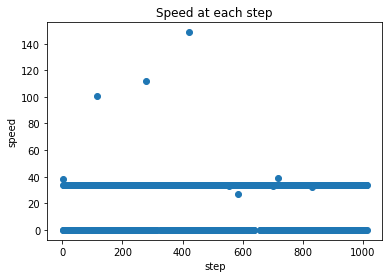

In [2]:
# get speed view
speed=drive_df[drive_df.tag=='speed']
plt.scatter(speed.step, speed.vals)
plt.title('Speed at each step')
plt.xlabel('step')
_=plt.ylabel('speed')

#### Why speed is flipping from 33MPH to 0MPH very often
We add some logging in the simulator and we found that at time step `t`
* when we are computing the next_x and next_y, the car might consume some more points (from previous planned path)
* when the simulator received the next_x, next_y, the car might be at some point very close to one point in this planned path (but not exact) due to this the speed is close to 0

Here is the illustration at time step `t=1`

step 1 [ 909.7784  910.0784] [ 1128.838  1128.84 ]
step 2 [ 910.0783] [ 1128.84]


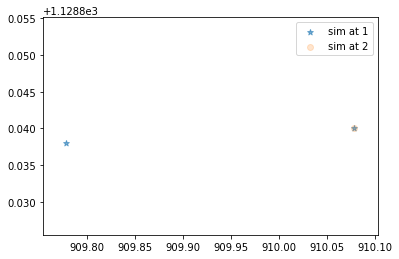

In [3]:
markers = ['o','*']
for t in range(1, 3):
    sim_x = sim_df[sim_df.step==t].x.values
    sim_y = sim_df[sim_df.step==t].y.values
    print('step {}'.format(t), sim_x, sim_y)
    plt.scatter(sim_x, sim_y, 
                marker=markers[t%len(markers)], 
                label='sim at {}'.format(t), alpha=1-0.4*t)
    
_=plt.legend()

One can see that at the step 2, we start at a point very close to the point that we already parsed. This is the main reason that causes the speed flipping between 0MPH and 33MPH.

#### Why it breaks speed limit
Note that we works on Frenet coordinate with constant speed in `s` direction. However, when translate into Cartesian, the speed can be very different especially when the road is curvy for example at time step `t=116`

In [4]:
print(np.where(speed.vals>50))

(array([116, 277, 419]),)


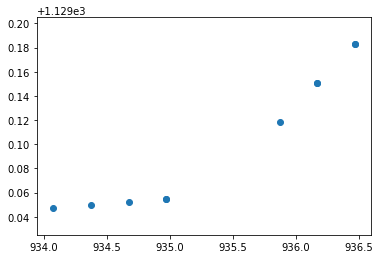

In [5]:
x_steps = np.array([])
y_steps = np.array([])

x_nearestwp = []
y_nearestwp = []
for t in range(110,120):
    x_steps=np.append(x_steps, sim_df[sim_df.step==t].x.values)
    y_steps=np.append(y_steps, sim_df[sim_df.step==t].y.values)
    
    
plt.scatter(x_steps, y_steps)

We can see at step 115 to 116, the two points is quite far apart, let's look at the nearest waypoints

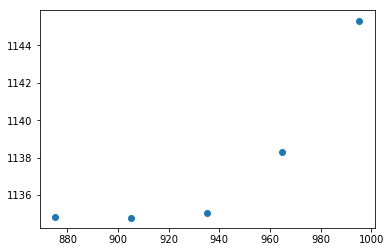

In [10]:
from utils import Highway

hwm = Highway('data/highway_map.csv')
inearest = []
for x,y in zip(x_steps, y_steps):
    inearest.append(hwm.closestWaypoint(x, y))
  
_=plt.scatter(high_way.x[np.min(inearest)-2:np.max(inearest)+3], 
              high_way.y[np.min(inearest)-2:np.max(inearest)+3])

One can find the the road is quite curvy which can cause that by changing in Frenet by 33MPH, it can be much bigger in Cartesian. This is the reason that causes our car breaking speed-limit.

#### Why the trajectory is not smooth
Note that we **regenerate** a trajectory in Frenet coordinate and convert back to Cartesian. This conversion between Frenet and Cartesian is not very precise since

* the highway maps is quite sparse (each consecutive points have a distance of `30m`)
* the convert from Cartesian to Frenet then revert back to Cartesian can have big inconsistence.

Here is an example

Max x-diff 30.404008997964866
Max y-diff 30.404008997964866


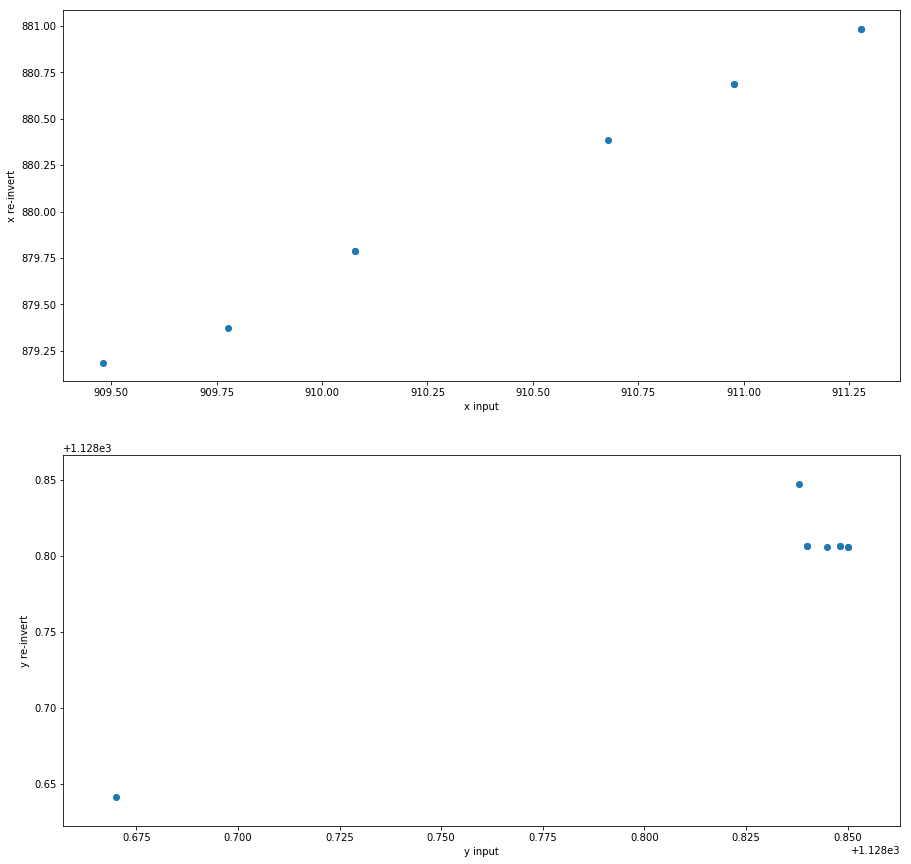

In [11]:
x_y_yaw = []
s_d = []
x_y_reinvert = []
for t in range(1,10):
    idx = 12 * (t - 1)

    x = drive_df.vals[idx]
    y = drive_df.vals[idx + 1]
    yaw = drive_df.vals[idx + 4]
    x_y_yaw.append([x,y,yaw])
    s,d = hwm.getFrenet(x, y, yaw)
    x,y = hwm.getXY(s, d)
    x_y_reinvert.append([x, y])
    
x_y_yaw = np.array(x_y_yaw)
x_y_reinvert = np.array(x_y_reinvert)
f, axs = plt.subplots(2,1,figsize=(15,15))
axs[0].scatter(x_y_yaw[:, 0], x_y_reinvert[:, 0])
axs[0].set_xlabel('x input')
axs[0].set_ylabel('x re-invert')
axs[1].scatter(x_y_yaw[:, 1], x_y_reinvert[:, 1])
axs[1].set_xlabel('y input')
axs[1].set_ylabel('y re-invert')

print('Max x-diff {}'.format(np.max(np.abs(x_y_yaw[:, 0] - x_y_reinvert[:, 0]))))
print('Max y-diff {}'.format(np.max(np.abs(x_y_yaw[:, 0] - x_y_reinvert[:, 0]))))

Note that the highway map has each consecutive points is 30m apart so when we convert back and forth between Cartesian and Frenet, it's quite easy to introduce these error.

### Solution
We need to find solution for the above issue
* latency: to tackle this, we need to use previous_path_x, previous_path_y and we append the next points into this list. This will ensure our trajectory is continuous and speed won't go to 0
* speed-limit: we need to ensure the car's speed in Cartesian (more detail in the following)
* trajectory not smooth: we should keep previous_path_x, previous_path_y and we append the next planner points into the list. Note that to handle the inconsistence due to conversion between Frenet and Cartesian one can Spline to interpolate the highway points to make it 1m apart (instead of 30m apart).

#### Using the previous path to tackle latency
The implementation is done in `getTrajectoryKeepLaneAppending`

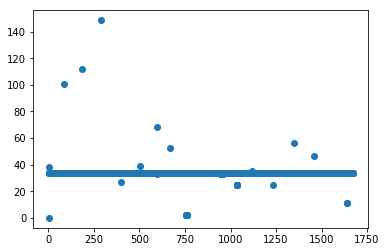

In [15]:
drive2_df = pd.read_csv('build/experiment2-drive.csv', delimiter=';', 
                 names=['step', 'tag', 'vals'], 
                 converters={'vals' : lambda x: eval(x)})
sim2_df = pd.read_csv('build/experiment2-sim.csv', names=['step', 'x', 'y'], delimiter=' ')
speed2 = drive2_df[drive2_df.tag=='speed']
plt.scatter(speed2.step, speed2.vals)

In [56]:
print(speed2[speed2.vals < 20])

       step    tag    vals
5         1  speed       0
9041    754  speed   2.177
9053    755  speed   2.242
9065    756  speed   2.251
9077    757  speed   2.242
9089    758  speed   2.236
9101    759  speed   2.242
9113    760  speed   2.251
9125    761  speed   2.242
9137    762  speed    2.25
19661  1639  speed  10.984
19673  1640  speed   11.06


49


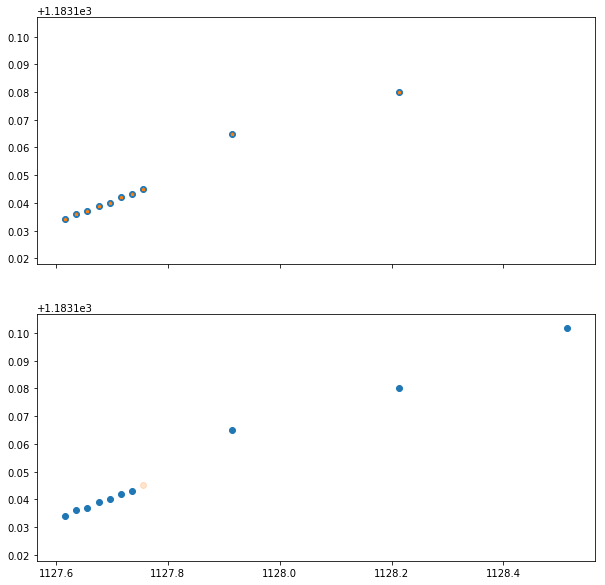

In [57]:
f, axs = plt.subplots(2,1,figsize=(10,10),sharex=True, sharey=True)
idx = 753*12
print(len(drive2_df.vals[idx + 8]))
axs[0].scatter(drive2_df.vals[idx + 8][:10], drive2_df.vals[idx+9][:10])
axs[0].scatter(drive2_df.vals[idx + 10][:10], drive2_df.vals[idx + 11][:10], s=10, marker='*')
axs[0]  
    
idx += 12
axs[1].scatter(drive2_df.vals[idx + 10][:10], drive2_df.vals[idx + 11][:10])
axs[1].scatter(drive2_df.vals[idx], drive2_df.vals[idx+1],alpha=0.2)

We can see that the speed is mostly at 33MPH (which is expected). We still see breaking limit issue (but this is expected since we haven't tackled it). Some point the speed is quite small, this is due to the conversion between between Cartesian and Frenet.

#### Control car speed limit in Cartesian
In this part, we try two things:

* ensure car speed in Cartesian
* use Spline to plan next point
* do planning in car's local coordinate

This is implemented in `getTrajectoryKeepLaneSpline`

In [2]:
nb_row_per_step = len(df[df.step==1])
tag_to_idx = {df.tag[i] : i for i in range(nb_row_per_step)}

The highway data consists
* x, y: are the waypoint's map coordinate position
* s: is the distance along the road to get to the waypoint in meters
* dx, dy: values define the unit normal vector pointing outward of the highway loop

In [3]:
high_way.head()

,x,y,s,dx,dy
0,784.6001,1135.571,0.000000,-0.023598,-0.999722
1,815.2679,1134.930,30.674479,-0.010995,-0.999940
2,844.6398,1134.911,60.046371,-0.002048,-0.999998
3,875.0436,1134.808,90.450415,-0.001848,-0.999998
4,905.2830,1134.799,120.689735,0.004131,-0.999992


In [4]:
high_way.tail()

,x,y,s,dx,dy
176,594.5000,1211.000,6735.577816,-0.661828,-0.749655
177,630.9000,1181.300,6782.557053,-0.564178,-0.825653
178,670.6000,1159.000,6828.091419,-0.425906,-0.904767
179,711.2000,1143.500,6871.549595,-0.263706,-0.964603
180,753.2067,1136.417,6914.149258,-0.107399,-0.994216


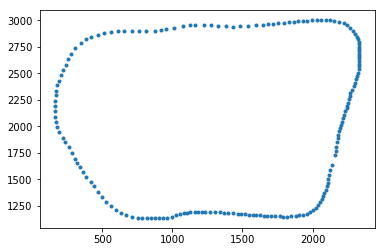

In [5]:
_ = plt.plot(high_way.x, high_way.y, '.')

## Speed violated

#### Why speed becomes close to 0.
The first version of following lane always use same d and varies s, then convert back to Cartersian (x,y). 
We observe that the speed can become very close to 0.0. This is due to latency, so each time we compute the next_x_path, next_y_path, the car is already advanced to the next points that very close to this planned points. This cause the speed change abruptly.

This can be fixed by keep using `previous_path_x, previous_path_y`, and we only add new points at the end.

#### Why speed becomes > 50MPH
Here is where we got speed > 50MPH

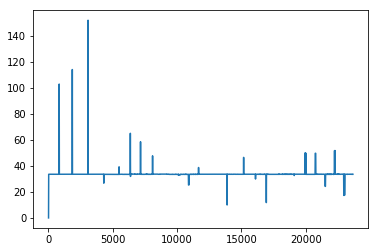

In [6]:
speed = df[df.tag=='speed']
plt.plot(speed.vals)

In [7]:
speed.loc[speed.vals > 50]

,epochs,step,tag,vals
833,0.030349,70,speed,102.873
1853,0.017470,155,speed,114.028
3077,0.033938,257,speed,151.921
6365,0.025120,531,speed,65.033
7157,0.023674,597,speed,58.526
22241,0.028401,1854,speed,51.731
22265,0.034020,1856,speed,51.705
22277,0.033624,1857,speed,51.772


In [8]:
speed.loc[speed.vals < 25]

,epochs,step,tag,vals
5,20.654653,1,speed,0
13889,0.024823,1158,speed,9.934
16937,0.025297,1412,speed,11.775
21509,0.028777,1793,speed,24.26
21521,0.028253,1794,speed,24.277
21533,0.030017,1795,speed,24.262
22961,0.058218,1914,speed,17.298
22973,0.027422,1915,speed,17.347
22985,0.018302,1916,speed,17.391
22997,0.023755,1917,speed,17.366


In [9]:
import numpy as np

def get_states(df, steps):
    rows = []
    for step in steps:
        idx = 12*(step - 1)
        rows.append([step] + [df.vals[i] for i in range(idx, idx + 8)])
    
    columns = ['step'] + list(df.tag[0:8].values)
    return pd.DataFrame(rows, columns = columns)

get_states(df, range(1,10))

,step,x,y,s,d,yaw,speed,end_path_s,end_path_d
0,1,909.48,1128.670,124.834,6.165,0.000,0.000,0.000,0.000
1,2,909.78,1128.673,125.133,6.164,0.479,33.534,139.833,6.166
2,3,910.98,1128.683,126.334,6.165,0.572,33.554,140.133,6.166
3,4,911.58,1128.688,126.933,6.165,0.478,33.553,141.333,6.166
4,5,911.88,1128.691,127.234,6.165,0.479,33.561,141.933,6.167
5,6,912.18,1128.693,127.533,6.165,0.479,33.540,142.233,6.167
6,7,912.48,1128.696,127.833,6.165,0.572,33.554,142.533,6.168
7,8,912.78,1128.699,128.133,6.164,0.478,33.561,142.833,6.168
8,9,913.38,1128.704,128.733,6.165,0.478,33.554,143.133,6.169


At each step, we compute the next_x_vals, next_y_vals and check from the next steps to see which points are consumed

In [10]:
def get_next_step(df, step, nb_row=10, debug=False):
    next_x_vals = df.vals[nb_row_per_step * (step - 1) + tag_to_idx['next_x_vals']]
    next_y_vals = df.vals[nb_row_per_step * (step - 1) + tag_to_idx['next_y_vals']]
    prev_path_x = df.vals[nb_row_per_step * step + tag_to_idx['previous_path_x']]
    prev_path_y = df.vals[nb_row_per_step * step + tag_to_idx['previous_path_y']]
    
    consumed = [True]*(len(next_x_vals) - len(prev_path_x)) + [False] * len(prev_path_x)
    nb_row = max(len(next_x_vals) - len(prev_path_x) + 1, nb_row)
    steps = [step] * nb_row
    if (debug):
        print('current pos (x, y) = ({}, {})'.format(df.vals[(df.step==step) & (df.tag=='x')].values[0],
                                                     df.vals[(df.step==step) & (df.tag=='y')].values[0]))
    return pd.DataFrame({'next_x_vals' : next_x_vals[:nb_row], 
                         'next_y_vals' : next_y_vals[:nb_row],
                         'consumed'    : consumed[:nb_row],
                         'step' : steps}, 
                        columns=['step', 'next_x_vals', 'next_y_vals', 'consumed'])

In [11]:
get_next_step(df, 1)

,step,next_x_vals,next_y_vals,consumed
0,1,909.78,1128.673,True
1,1,910.08,1128.675,False
2,1,910.38,1128.678,False
3,1,910.68,1128.680,False
4,1,910.98,1128.683,False
5,1,911.28,1128.686,False
6,1,911.58,1128.688,False
7,1,911.88,1128.691,False
8,1,912.18,1128.693,False
9,1,912.48,1128.696,False


In [12]:
get_next_step(df, 2)

,step,next_x_vals,next_y_vals,consumed
0,2,910.08,1128.675,True
1,2,910.38,1128.678,True
2,2,910.68,1128.680,True
3,2,910.98,1128.683,True
4,2,911.28,1128.686,False
5,2,911.58,1128.688,False
6,2,911.88,1128.691,False
7,2,912.18,1128.693,False
8,2,912.48,1128.696,False
9,2,912.78,1128.699,False


We notice that at each step, we might consume one or more points, each point tooks 0.02 second. Let collate all points that our car parsed:

In [13]:
def collate_step(df):
    last_step = df.step.values[-1]
    steps = []
    x_vals = []
    y_vals = []
    
    for step in range(1, last_step):
        if step == 1:
            steps.append(step)
            x_vals.append(df.vals[nb_row_per_step * (step - 1) + tag_to_idx['x']])
            y_vals.append(df.vals[nb_row_per_step * (step - 1) + tag_to_idx['y']])
        else:
            next_x_vals = df.vals[nb_row_per_step * (step - 2) + tag_to_idx['next_x_vals']]
            next_y_vals = df.vals[nb_row_per_step * (step - 2) + tag_to_idx['next_y_vals']]
            
            prev_path_x = df.vals[nb_row_per_step * (step - 1) + tag_to_idx['previous_path_x']]
            prev_path_y = df.vals[nb_row_per_step * (step - 1) + tag_to_idx['previous_path_y']]
            
            nb_point = len(next_x_vals) - len(prev_path_x)
            
            steps += [step] * nb_point
            x_vals += list(next_x_vals[:nb_point])
            y_vals += list(next_y_vals[:nb_point])
    
    return pd.DataFrame({'step'   : steps,
                         'x_vals' : x_vals,
                         'y_vals' : y_vals}, 
                        columns = ['step', 'x_vals', 'y_vals'])

df_steps = collate_step(df)

Let's visualize our trajectory

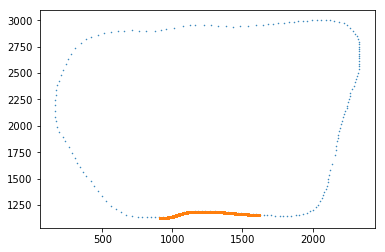

In [14]:
_ = plt.plot(high_way.x, high_way.y, '.', markersize=1)
_ = plt.plot(df_steps.x_vals, df_steps.y_vals, 'o', markersize=2)

We can compute the speed as following

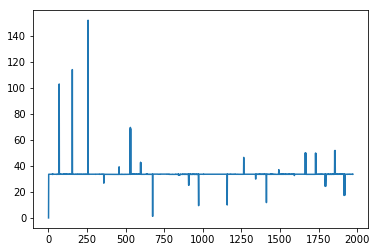

In [15]:
def convert_mps_milesph(mps):
    return mps*2.236934

speeds = np.sqrt(np.diff(df_steps.x_vals.values)**2 + 
                 np.diff(df_steps.y_vals.values)**2) / 0.02
speeds = np.append([0], convert_mps_milesph(speeds))
df_steps['speed'] = speeds

df_steps_unique = df_steps.drop_duplicates('step',keep='first')
plt.plot(df_steps.step, df_steps.speed.values,'-', markersize=1)


In [16]:
np.unique(df_steps[df_steps.speed > 50].step.values)

array([  70,  155,  257,  531,  532, 1854, 1856, 1857])

In [17]:
speed.loc[speed.vals > 50].step.values

array([  70,  155,  257,  531,  597, 1854, 1856, 1857])

In [18]:
print(np.unique(df_steps[df_steps.speed < 25].step))
print(speed.loc[speed.vals < 25].step.values)

[   1  675  973 1158 1412 1793 1794 1795 1914 1915 1916 1917 1919]
[   1 1158 1412 1793 1794 1795 1914 1915 1916 1917 1919]


We look at an index where speed breaks its limit

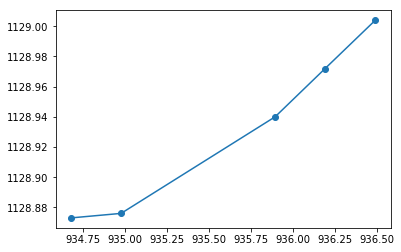

In [19]:
idx = df_steps['step'].between(69,71)
plt.plot(df_steps[idx].x_vals, df_steps[idx].y_vals, '-o')

We can clearly see that the 2nd and 3rd points are too far apart and the change in yaw is too quick.

Note that we have use Frenest and set s_inc = 0.3, the speed should NOT break the limit. However note that the convert between Frenet and Catersian is not precise, that's why we see a big speed here.

### How to ensure speed limit